In [1]:
%%capture
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# BlackJack simulator



### Planned steps

1. ~~Make the random function work (make sure the arguments inside local functions work properly)~~
2. ~~Make Basic Strategy engine~~
3. ~~Make the function appened to data frame~~
3. ~~Make bets - possible outcomes~~
3. Make "miss engine" - one that every one in a while misses the best move
1. Make exceptions engine - to take into account true count into play


In [2]:
#defining deck and cards properties

suits = ['Spade', 'Club', 'Diamond', 'Heart']
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
possible_cards = [f'{suit} {rank}' for suit in suits for rank in ranks]
starting_deck = list(possible_cards)
cards_value = {f'{suit} {rank}': int(rank) if rank.isdigit() else 10 if rank in ['J', 'Q', 'K'] else 11 for suit in suits for rank in ranks}

In [3]:
print(random.choice(possible_cards))

Heart K


In [4]:
def shuffle(decks):
    #building a deck
    global deck
    deck = random.sample(starting_deck, len(starting_deck))
    for i in range(decks - 1):
        deck += random.sample(starting_deck, len(starting_deck))
    return deck

In [5]:
#testing the results of function shuffle
deck = shuffle(decks=6)
print(deck)
print(deck.count("Heart A"))

['Heart 7', 'Spade 4', 'Diamond 8', 'Spade 9', 'Heart A', 'Diamond J', 'Heart 9', 'Diamond K', 'Diamond 9', 'Diamond 7', 'Spade 5', 'Club 8', 'Spade 10', 'Club 2', 'Diamond A', 'Spade A', 'Diamond 3', 'Club Q', 'Diamond 4', 'Club 3', 'Spade 8', 'Diamond Q', 'Club 10', 'Club A', 'Diamond 6', 'Club 5', 'Spade 2', 'Heart 5', 'Heart 4', 'Heart 3', 'Heart 8', 'Club J', 'Spade 6', 'Club K', 'Heart K', 'Spade K', 'Heart 10', 'Spade J', 'Club 9', 'Heart 2', 'Heart Q', 'Club 7', 'Heart 6', 'Diamond 5', 'Diamond 10', 'Club 6', 'Heart J', 'Spade 7', 'Spade 3', 'Spade Q', 'Diamond 2', 'Club 4', 'Club 9', 'Club 8', 'Spade 5', 'Club Q', 'Heart K', 'Diamond 7', 'Club 10', 'Diamond 3', 'Diamond 5', 'Club 4', 'Club 2', 'Diamond 10', 'Heart 7', 'Heart J', 'Heart 9', 'Diamond 4', 'Club 7', 'Diamond K', 'Club 6', 'Spade 2', 'Diamond 9', 'Spade A', 'Diamond A', 'Spade 10', 'Heart Q', 'Diamond 8', 'Heart 5', 'Heart 4', 'Club K', 'Diamond 6', 'Club J', 'Spade Q', 'Spade 3', 'Heart 6', 'Spade 6', 'Heart 8', '

In [10]:
def game_of_blackjack(bet : int = 1, players_engine : str = "basic") -> int:  
    """plays single game of blackjack

    Parameters
    ----------
    players_engine: str
        type of engine to be used

    Returns
    -------
    int
        calculated value of a game
    """
    global deck
    #drawing cards
    players_cards = [deck[0]]
    deck.pop(0)
    players_cards += [deck[0]]
    deck.pop(0)
    dealers_cards = [deck[0]]
    deck.pop(0)
    dealers_cards += [deck[0]]
    deck.pop(0)


    #DataFrame for trackability of hands and bets
    df = pd.DataFrame(columns=['Hand', 'Bet', 'Status', 'Outcome'])
    #Hand is a list of stings containing hands cards
    #Bet is an integer of the bet size for given hand 
    #Status is a sting to indicate if hand is active, played or finished
    #Outcome is the financial result
    df.loc[0,:] = [players_cards, bet, 'Active', None]

    
    def get_value(played_hand: list['str']):
        #hand should be a list argument
        
        #calculate value and adjust for aces
        value = 0
        for card in list(played_hand):
            value += cards_value[card]
            
        aces = 0
        for card in list(played_hand): 
            if card[-1] == "A":
                aces += 1

        while value > 21 and aces >0:
            aces -= 1
            value -= 10
        
        if players_engine == 'rand':
            return value
        else: return value, aces

    #checking for dealers BlackJack
    if cards_value[dealers_cards[0]] in [10, 11]:
        value_dealer, aces_dealer = get_value(dealers_cards)
        if value_dealer == 21:
            for index, row in df.iterrows():
                hand_value, hand_aces = get_value(row['Hand'])
                if hand_value ==21:
                    df.at[index, 'Outcome'] = df.at[index, "Bet"]
                    df.at[index, 'Status'] = 'Finished'
                else:
                    df.at[index, 'Outcome'] = 0
                    df.at[index, 'Status'] = 'Finished'


               
    def check_for_bust(hand_index: int) -> bool:
        played_hand = df.at[hand_index, 'Hand']
        value_hand, aces_hand = get_value(played_hand)
        if value_hand > 21:
            if players_engine == 'rand':
                print("Casino wins")
            df.at[hand_index, 'Status'] = 'Finished'
            df.at[hand_index, 'Outcome'] = 0
            return True
        else:
            return False


    def split(hand_index: int) -> None:
        played_hand = df.at[hand_index, 'Hand']
        played_hand = list(played_hand)
        if len(played_hand) != 2 or cards_value[played_hand[0]] != cards_value[played_hand[1]]:
            return False
        hand2 = [played_hand[1]]
        list(hand2)
        played_hand.pop(1)
        played_hand.append(deck[0])
        deck.pop(0)
        df.at[hand_index, 'Hand'] = played_hand
        hand2.append(deck[0])
        deck.pop(0)
        df.loc[len(df)] = [hand2, df.at[hand_index, 'Bet'], 'Active', None]
        return


    
    def double(hand_index : int) -> None:
        played_hand = df.at[hand_index, 'Hand']
        played_hand = list(played_hand)
        if len(played_hand) != 2 or get_value(played_hand) == 21:
            return False
        played_hand.append(deck[0])
        deck.pop(0)
        df.at[hand_index, 'Hand'] = played_hand
        df.at[hand_index, 'Bet'] = 2*int(df.at[hand_index, 'Bet'])
        if check_for_bust(hand_index = hand_index) == False:
            stand(hand_index = hand_index)
        return True

    
    def hit(hand_index : int) -> None:
        played_hand = df.at[hand_index, 'Hand']
        played_hand = list(played_hand)
        if get_value(played_hand) == 21:
            return False
        played_hand.append(deck[0])
        deck.pop(0)
        df.at[hand_index, 'Hand'] = played_hand
        check_for_bust(hand_index=hand_index)
        return True


    def stand(hand_index : int) -> None:
        df.loc[hand_index, "Status"] = 'Played'
        return


    def casino_move():

        value_dealer, aces_dealer = get_value(dealers_cards)
                        
        while value_dealer < 17:
            dealers_cards.append(deck[0])
            deck.pop(0)
            value_dealer, aces_dealer = get_value(dealers_cards)
            if value_dealer > 21:
                for index, row in df.iterrows():
                    if df.at[index, 'Status'] == 'Played':
                        df.at[index, 'Outcome'] = 2*int(df.at[index, 'Bet'])
                        df.at[index, 'Status'] = 'Finished'

                            
        for index, row in df.iterrows():
            value_hand, hand_aces = get_value(df.at[index, 'Hand'])
            if df.at[index, 'Status'] == 'Played':
                if value_dealer == value_hand:
                    df.at[index, 'Outcome'] = df.at[index, 'Bet']
                    df.at[index, 'Status'] = 'Finished'
                elif value_dealer > value_hand:
                    df.at[index, 'Outcome'] = 0
                    df.at[index, 'Status'] = 'Finished'
                else:
                    df.at[index, 'Outcome'] = 2*int(df.at[index, 'Bet'])
                    df.at[index, 'Status'] = 'Finished'


    # if players_engine == 'rand':
    #     print("Game starts...")

    #checking for BlackJack
    v1, a1 = get_value(players_cards)
    if v1 == 21:
        df.at[0, 'Outcome'] = 2.5*int(df.at[0, 'Bet'])
        df.at[0, 'Status'] = 'Finished'



    if players_engine == "basic":
        while len(df[df['Status'] == 'Active']) > 0:
            f_active_hand_index = df[df['Status'] == 'Active'].index[0] #defines the index of first active hand
            f_active_hand = df.at[f_active_hand_index, 'Hand'] #defines the first active hand
            value, aces = get_value(f_active_hand)
            if len(f_active_hand) == 1:
                hit(f_active_hand_index)
                f_active_hand = df.at[f_active_hand_index, 'Hand']
                #defining spliting logic for basic strategy
            f_active_hand_index = df[df['Status'] == 'Active'].index[0] #defines the index of first active hand
            f_active_hand = df.at[f_active_hand_index, 'Hand'] #defines the first active hand
            if cards_value[f_active_hand[0]] == cards_value[f_active_hand[1]] and len(f_active_hand) == 2:    
                if cards_value[f_active_hand[0]] in [8, 11]:
                    split(f_active_hand_index)
                elif cards_value[f_active_hand[0]] == 9:
                    if cards_value[dealers_cards[0]] not in [7, 10, 11]:
                        split(f_active_hand_index)
                elif cards_value[f_active_hand[0]] in [2, 3, 7]:
                    if cards_value[dealers_cards[0]] < 8:
                        split(f_active_hand_index) 
                elif cards_value[f_active_hand[0]] == 6:
                    if cards_value[dealers_cards[0]] < 7:
                        split(f_active_hand_index)
                elif cards_value[f_active_hand[0]] == 4:
                    if cards_value[dealers_cards[0]] in [5, 6]:
                        split(f_active_hand_index)

            f_active_hand_index = df[df['Status'] == 'Active'].index[0] #defines the index of first active hand
            f_active_hand = df.at[f_active_hand_index, 'Hand'] #defines the first active hand
             
            if aces == 0:
            #this corresponds to a 'hard' hand, below the logic for this scenario
                if value > 16:
                    stand(f_active_hand_index)
                elif value in range(13, 17):
                    if cards_value[dealers_cards[0]] < 7:
                        stand(f_active_hand_index)
                    else: hit(f_active_hand_index)
                elif value == 12:
                    if cards_value[dealers_cards[0]] in [4, 5, 6]:
                        stand(f_active_hand_index)
                    else: hit(f_active_hand_index)
                elif value == 11:
                    if double(f_active_hand_index) == False:
                        hit(f_active_hand_index)
                    else: hit(f_active_hand_index)
                elif value == 10:
                    if cards_value[dealers_cards[0]] < 10:
                        if double(f_active_hand_index) == False:
                            hit(f_active_hand_index)
                    else: hit(f_active_hand_index)
                elif value == 9:
                    if cards_value[dealers_cards[0]] in range(3,7):
                        if double(f_active_hand_index) == False:
                            hit(f_active_hand_index)
                    else: hit(f_active_hand_index)
                else: hit(f_active_hand_index)
                    

            elif aces > 0:
            #this correcponds to a 'soft' hand, below the logic for this scenario 
                if value > 19:
                    stand(f_active_hand_index)
                elif value == 19:
                    if cards_value[dealers_cards[0]] == 6:
                        if double(f_active_hand_index) == False:
                            stand(f_active_hand_index)
                    else: stand(f_active_hand_index)
                elif value == 18:
                    if cards_value[dealers_cards[0]] in range(2,7):
                        if double(f_active_hand_index) == False:
                            stand(f_active_hand_index)
                    elif cards_value[dealers_cards[0]] in [7, 8]:
                        stand(f_active_hand_index)
                    else: hit(f_active_hand_index)
                elif value in range(13, 18) and cards_value[dealers_cards[0]] in [5, 6]:
                    if double(f_active_hand_index) == False:
                        hit(f_active_hand_index)
                elif value in range(15,18) and cards_value[dealers_cards[0]] == 4:
                    if double(f_active_hand_index) == False:
                        hit(f_active_hand_index)
                elif value == 17 and cards_value[dealers_cards[0]] == 3:
                    if double(f_active_hand_index) == False:
                        hit(f_active_hand_index)
                else: hit(f_active_hand_index)
    
        casino_move()
        return df, dealers_cards

In [17]:
def BJ_simulator(iterations: int, shoe_size: int, bet_size: int, games_per_deck=5):
    
    data = pd.DataFrame({'Starting cards': [], 'Dealers card': [], 'Hands amount': [], '$result': [], 'Starting running count': [],'Cards left at start': [], 'Cards Left after the game':[]})
    # $result = game winnings - bets(game cost)
    
    for i in range(iterations):
        deck = shuffle(decks=shoe_size)
        for n in range(games_per_deck*shoe_size):
            true_count = 0
            for card in list(deck):
                if cards_value[card] in [10, 11]:
                    true_count += 1
                elif cards_value[card] in range(2, 7):
                    true_count -= 1
            try:
                cards_at_start = len(deck)
                df, dealer_cards = game_of_blackjack(bet = bet_size, players_engine = 'basic')
                cards_left = len(deck)
                result = df['Outcome'].sum() - df['Bet'].sum()
                starting_cards = list(df.loc[0,'Hand'])[:2]
                w = pd.DataFrame({'Starting cards': [starting_cards], 'Dealers card': [dealer_cards[0]],'Hands amount':[len(df)], '$result': [result], 'Starting running count': [true_count], 'Cards left at start': [cards_at_start], 'Cards Left after the game':[cards_left]})
                data = pd.concat([data, w], ignore_index=True, axis=0)
            except ValueError as e:
                pass
    return data

In [67]:
data=BJ_simulator(iterations=10,shoe_size=8,bet_size=100, games_per_deck=7)
print(data['$result'].sum())
data

500.0


,Starting cards,Dealers card,Hands amount,$result,Starting running count,Cards left at start,Cards Left after the game
0,"[Heart 4, Spade 7]",Diamond 7,1.0,-200.0,0.0,416.0,410.0
1,"[Spade 8, Heart 3]",Club 7,1.0,-200.0,-2.0,410.0,404.0
2,"[Club 3, Club 8]",Club 6,1.0,-200.0,-2.0,404.0,396.0
3,"[Heart Q, Diamond K]",Club A,1.0,100.0,2.0,396.0,391.0
4,"[Heart 8, Heart A]",Spade A,1.0,-100.0,1.0,391.0,387.0
...,...,...,...,...,...,...,...
555,"[Diamond 2, Club 2]",Heart 9,1.0,-100.0,1.0,133.0,127.0
556,"[Diamond 7, Club Q]",Spade A,1.0,100.0,2.0,127.0,121.0
557,"[Diamond 5, Diamond 9]",Heart 4,1.0,-100.0,-1.0,121.0,116.0
558,"[Heart 3, Diamond 8]",Heart 10,1.0,-200.0,0.0,116.0,110.0


In [68]:
data['True count'] = data['Cards left at start']/data['Starting running count']/52

In [69]:
data.head(10)

,Starting cards,Dealers card,Hands amount,$result,Starting running count,Cards left at start,Cards Left after the game,True count
0,"[Heart 4, Spade 7]",Diamond 7,1.0,-200.0,0.0,416.0,410.0,inf
1,"[Spade 8, Heart 3]",Club 7,1.0,-200.0,-2.0,410.0,404.0,-3.942308
2,"[Club 3, Club 8]",Club 6,1.0,-200.0,-2.0,404.0,396.0,-3.884615
3,"[Heart Q, Diamond K]",Club A,1.0,100.0,2.0,396.0,391.0,3.807692
4,"[Heart 8, Heart A]",Spade A,1.0,-100.0,1.0,391.0,387.0,7.519231
5,"[Diamond 5, Club 9]",Club 10,1.0,-100.0,-2.0,387.0,381.0,-3.721154
6,"[Club J, Spade 4]",Club K,1.0,-100.0,-2.0,381.0,373.0,-3.663462
7,"[Heart 7, Diamond 6]",Spade 9,1.0,-100.0,-1.0,373.0,368.0,-7.173077
8,"[Spade 6, Diamond 3]",Heart J,1.0,100.0,-2.0,368.0,362.0,-3.538462
9,"[Club 6, Diamond K]",Diamond J,1.0,100.0,-2.0,362.0,356.0,-3.480769


In [70]:
data.describe()

C:\Users\Tomo\.julia\conda\3\x86_64\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Hands amount,$result,Starting running count,Cards left at start,Cards Left after the game,True count
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,1.025000,0.892857,-0.798214,259.032143,253.333929,inf
std,0.177691,115.943308,2.445908,92.912229,92.899994,NaN
min,1.000000,-200.000000,-10.000000,90.000000,84.000000,-7.903846
25%,1.000000,-100.000000,-2.000000,176.750000,171.750000,-2.232372
50%,1.000000,0.000000,-1.000000,260.000000,253.500000,-0.730769
75%,1.000000,100.000000,1.000000,339.250000,333.250000,5.100962
max,3.000000,300.000000,8.000000,416.000000,412.000000,inf


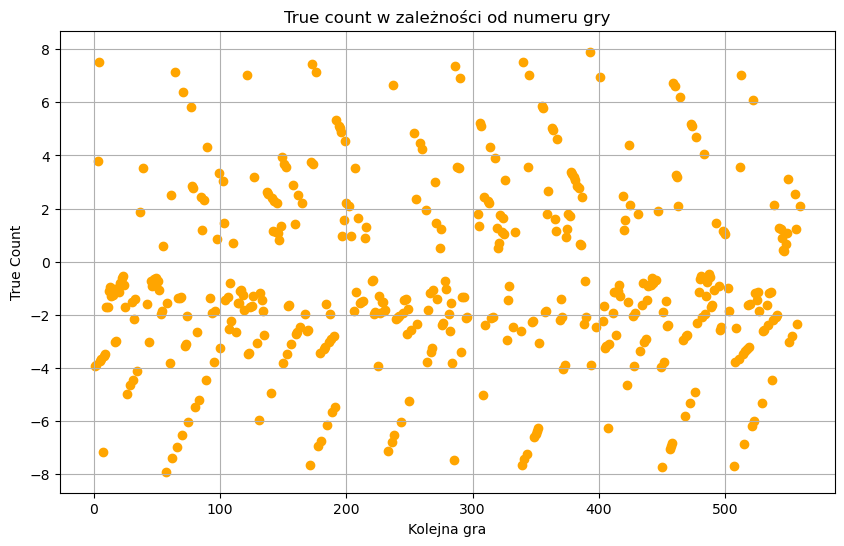

In [71]:
# Tworzenie wykresu kropkowego (scatter plot) dla wybranego zakresu danych
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['True count'], color='orange')
plt.title('True count w zależności od numeru gry')
plt.xlabel('Kolejna gra')
plt.ylabel('True Count')
plt.grid(True)
plt.show()


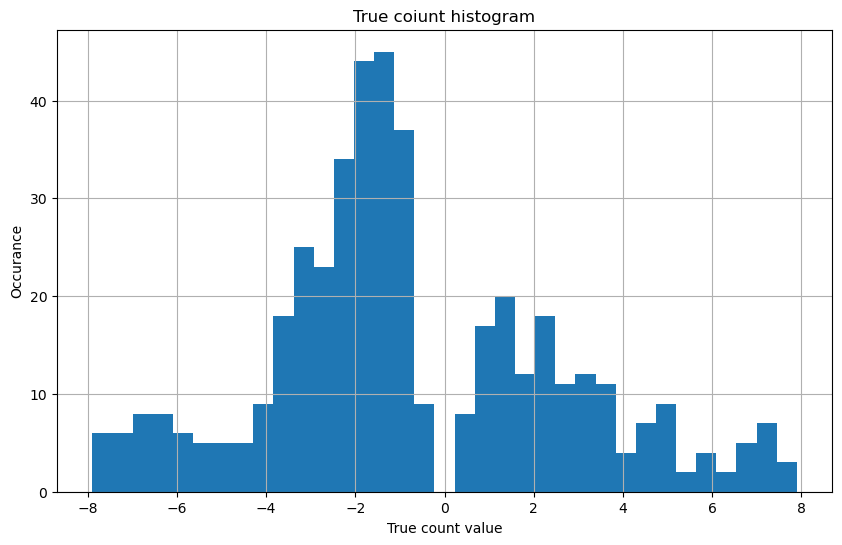

In [72]:
dset = data[data['True count'] < 100]

plt.figure(figsize=(10, 6))
dset['True count'].hist(bins=35)
plt.title('True coiunt histogram')
plt.xlabel('True count value')
plt.ylabel('Occurance')
plt.show()

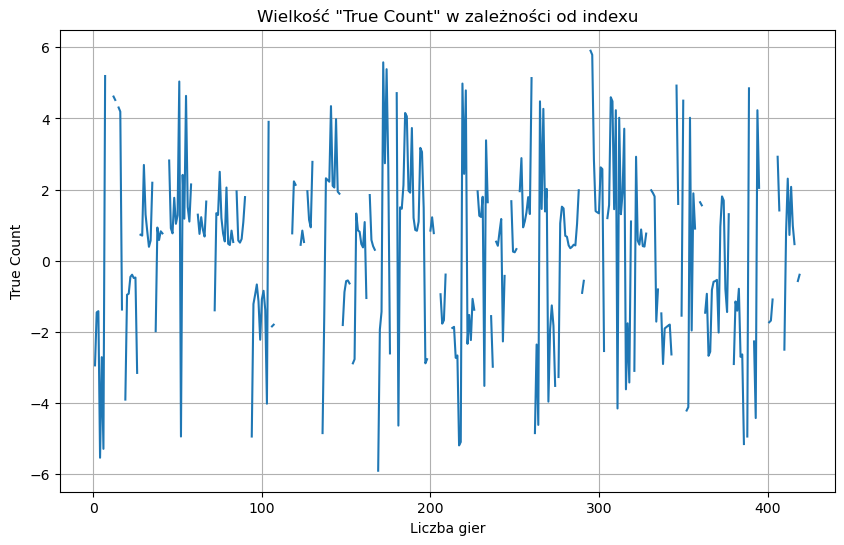

In [63]:
# Tworzenie wykresu liniowego
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['True count'])
plt.title('Wielkość "True Count" w zależności od indexu')
plt.xlabel('Liczba gier')
plt.ylabel('True Count')
plt.grid(True)
plt.show()
